# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0'

In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])



In [6]:
tf.DeviceSpec()

In [7]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

### Change directory

In [8]:
os.getcwd()

'c:\\Users\\knigh\\OneDrive\\Documents\\GL-PGP-AIML\\MySubmissions\\bangalore-aug19-batch-knightriderX\\advancedcv'

In [9]:
data_path = 'C:\\Users\\knigh\\OneDrive\\Study\\PGP-AIMLAug2019\\AdvancedCV\\ACV Lab Questions and Data Set\\'

os.chdir(data_path)

In [10]:
os.getcwd()

'C:\\Users\\knigh\\OneDrive\\Study\\PGP-AIMLAug2019\\AdvancedCV\\ACV Lab Questions and Data Set'

### Load the training data from train.csv file

In [11]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [12]:
train_labels.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [13]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [14]:
import csv

with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) -1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)

    next(spamreader, None)

    for i, row in enumerate(spamreader):
        for j, r in enumerate(row):
            if((j!=0) & (j!=3)):
                row[j] = int(r)

        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)

        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [15]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

In [16]:
from PIL import Image

In [17]:
os.getcwd()

'C:\\Users\\knigh\\OneDrive\\Study\\PGP-AIMLAug2019\\AdvancedCV\\ACV Lab Questions and Data Set'

In [18]:
images_Path = data_path+'images_racoon\\images\\'


In [19]:
images_Path

'C:\\Users\\knigh\\OneDrive\\Study\\PGP-AIMLAug2019\\AdvancedCV\\ACV Lab Questions and Data Set\\images_racoon\\images\\'

In [20]:

for i, fil in enumerate(paths):
    # print(i, fil)
    #print(images_Path+fil)
    img = Image.open(images_Path+fil)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [21]:
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')




In [22]:
base_model

In [23]:
model = base_model.layers[-1].output

model = Conv2D(4, kernel_size=4)(model)

model = Reshape((4,))(model)

In [24]:
myModel = Model(inputs = base_model.input, outputs = model)

### Define a custom loss function IoU which calculates Intersection Over Union

In [25]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tf.keras.backend.epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [26]:
myModel.summary()

ise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 8, 8, 192)    0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 8, 8, 64)     12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 8, 8, 64)     256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 8, 8, 384)    24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 8, 8, 384)    1536        block_7_expand[0][0]    

In [27]:
myModel.compile(loss="mse", optimizer="adam", metrics=[IoU]) 


In [28]:
myModel.fit(batch_images, coords, epochs=300,
                    batch_size = 32,                                      
                    workers=10,
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=1) 

9
Epoch 103/300
173/173 [==============================] - 1s 4ms/sample - loss: 58.8024 - IoU: 0.8421
Epoch 104/300
173/173 [==============================] - 1s 4ms/sample - loss: 54.1151 - IoU: 0.8422
Epoch 105/300
173/173 [==============================] - 1s 4ms/sample - loss: 56.8011 - IoU: 0.8118
Epoch 106/300
173/173 [==============================] - 1s 4ms/sample - loss: 58.6756 - IoU: 0.8223
Epoch 107/300
173/173 [==============================] - 1s 4ms/sample - loss: 60.7876 - IoU: 0.8034
Epoch 108/300
173/173 [==============================] - 1s 4ms/sample - loss: 59.2568 - IoU: 0.8136
Epoch 109/300
173/173 [==============================] - 1s 4ms/sample - loss: 57.1749 - IoU: 0.8268
Epoch 110/300
173/173 [==============================] - 1s 4ms/sample - loss: 61.0021 - IoU: 0.8252
Epoch 111/300
173/173 [==============================] - 1s 4ms/sample - loss: 63.6435 - IoU: 0.7959
Epoch 112/300
173/173 [==============================] - 1s 4ms/sample - loss: 69.1820 - 

### Pick a test image from the given data

In [29]:
test_img = images_Path+'\\raccoon-74.jpg'
unscaled = cv2.imread(test_img)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [30]:
IMAGE_SIZE

128

In [31]:
image_height , image_width, chnl = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image,dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [32]:
region = myModel.predict(x=np.array([feat_scaled]))[0]

In [33]:
region

array([ 29.634226,  29.260199, 139.06496 , 206.84297 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

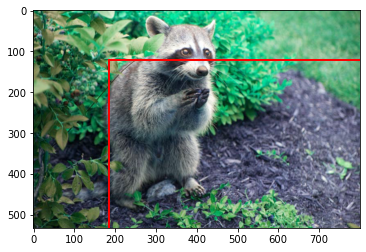

In [34]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
(x0, y0)

In [ ]:
(x1,y1)

In [ ]:
(x1 - x0) , (y1 - y0)

In [ ]:
fig

In [ ]:
ax